# Préparation

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import datetime
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from math import *
from sklearn.model_selection import train_test_split

x_centre = 3760901.5068
y_centre = -19238905.6133

train = pd.read_csv('data_train.csv')
test = pd.read_csv('data_test.csv')
train = train.drop(['Unnamed: 0'],axis=1)
test = test.drop(['Unnamed: 0'],axis=1)

tr = test.loc[test.x_exit.isnull()]

def conv(time_1):   
    sec1 = 3600*int(time_1[0:2]) + 60*int(time_1[3:5]) + int(time_1[6:8])                                                                                                                                
    return (sec1)

def distance(x1,x2,y1,y2):
    dist = np.sqrt(((x2-x1)**2)+((y2-y1)**2))
    return dist

def ecartTemps(t1,t2):
    ecart= t2-t1
    return ecart

def distanceCentre(x,y):
    dx = max(0,abs(x_centre-x)-10000)
    dy = max(0,abs(y_centre-y)-30000)
    return (dx**2+dy**2)

ecartTemps = np.vectorize(ecartTemps)

distance = np.vectorize(distance)
distanceCentre = np.vectorize(distanceCentre)
#vitesses négatives



test.vmin[test.vmin < 0] = np.NaN
test.vmean[test.vmean < 0] = np.NaN
test.vmax[test.vmax < 0] = np.NaN

train.vmin[train.vmin < 0] = np.NaN
train.vmean[train.vmean < 0] = np.NaN
train.vmax[train.vmax < 0] = np.NaN

#incohérences
train['vmean'][(train.time_entry==train.time_exit)] = 0
train['vmin'][(train.time_entry==train.time_exit)] = 0
train['vmax'][(train.time_entry==train.time_exit)] = 0

test['vmean'][(test.time_entry==test.time_exit)] = 0
test['vmin'][(test.time_entry==test.time_exit)] = 0
test['vmax'][(test.time_entry==test.time_exit)] = 0

train['vmax'][(train.x_entry==train.x_exit)&(train.y_entry==train.y_exit)] = 0
train['vmin'][(train.x_entry==train.x_exit)&(train.y_entry==train.y_exit)] = 0
train['vmean'][(train.x_entry==train.x_exit)&(train.y_entry==train.y_exit)] = 0

test['vmax'][(test.x_entry==test.x_exit)&(test.y_entry==test.y_exit)] = 0
test['vmin'][(test.x_entry==test.x_exit)&(test.y_entry==test.y_exit)] = 0
test['vmean'][(test.x_entry==test.x_exit)&(test.y_entry==test.y_exit)] = 0

#incohérences 2 

# train['vmean'][(train.time_entry!=train.time_exit)&(train.vmean == 0)] = np.NaN
# train['vmin'][(train.time_entry!=train.time_exit)&(train.vmin == 0)] = np.NaN
# train['vmax'][(train.time_entry!=train.time_exit)&(train.vmax == 0)] = np.NaN

# test['vmean'][(test.time_entry!=test.time_exit)&(test.vmean == 0)] = np.NaN
# test['vmin'][(test.time_entry!=test.time_exit)&(test.vmin == 0)] = np.NaN
# test['vmax'][(test.time_entry!=test.time_exit)&(test.vmax == 0)] = np.NaN

#train['vmax'][((train.x_entry!=train.x_exit)|(train.y_entry!=train.y_exit))&(train.vmax == 0)] = np.NaN
#train['vmin'][((train.x_entry!=train.x_exit)|(train.y_entry!=train.y_exit))&(train.vmin == 0)] = np.NaN
#train['vmean'][((train.x_entry!=train.x_exit)|(train.y_entry!=train.y_exit))&(train.vmean == 0)] = np.NaN

#test['vmax'][((test.x_entry!=test.x_exit)|(test.y_entry!=test.y_exit))&(test.vmax == 0)] = np.NaN
#test['vmin'][((test.x_entry!=test.x_exit)|(test.y_entry!=test.y_exit))&(test.vmin == 0)] = np.NaN
#test['vmean'][((test.x_entry!=test.x_exit)|(test.y_entry!=test.y_exit))&(test.vmean == 0)] = np.NaN

#outliers
train.vmean = train.vmean.loc[(train.vmean<90)]
train.vmax = train.vmean.loc[(train.vmax<90)]
train.vmin = train.vmean.loc[(train.vmin<90)]


#nan by mean
train['vmax']=train['vmax'].replace( np.NaN , train['vmax'].mean() )
train['vmin']=train['vmin'].replace( np.NaN , train['vmin'].mean() )
train['vmean']=train['vmean'].replace( np.NaN , train['vmean'].mean() )

test['vmax']=test['vmax'].replace( np.NaN , test['vmax'].mean() )
test['vmin']=test['vmin'].replace( np.NaN , test['vmin'].mean() )
test['vmean']=test['vmean'].replace( np.NaN , test['vmean'].mean() )

# trainTempVmean = train.loc[(train.vmean>0)]
# trainTempVmean = trainTempVmean.dropna()
# trainTempVmean = trainTempVmean.vmean.mean()

# trainTempVmax = train.loc[(train.vmax>0)]
# trainTempVmax = trainTempVmax.dropna()
# trainTempVmax = trainTempVmax.vmax.mean()

# trainTempVmin = train.loc[(train.vmin>0)]
# trainTempVmin = trainTempVmin.dropna()
# trainTempVmin = trainTempVmin.vmin.mean()

# testTempVmean = test.loc[(test.vmean>0)]
# testTempVmean = testTempVmean.dropna()
# testTempVmean = testTempVmean.vmean.mean()

# testTempVmax = test.loc[(test.vmax>0)]
# testTempVmax = testTempVmax.dropna()
# testTempVmax = testTempVmax.vmax.mean()

# testTempVmin = test.loc[(test.vmin>0)]
# testTempVmin = testTempVmin.dropna()
# testTempVmin = testTempVmin.vmin.mean()


# train['vmax']=train['vmax'].replace( np.NaN , trainTempVmax)
# train['vmin']=train['vmin'].replace( np.NaN , trainTempVmin)
# train['vmean']=train['vmean'].replace( np.NaN , trainTempVmean)
# test['vmax']=test['vmax'].replace( np.NaN , testTempVmax)
# test['vmin']=test['vmin'].replace( np.NaN , testTempVmin)
# test['vmean']=test['vmean'].replace( np.NaN , testTempVmean)

vec_conv =  np.vectorize(conv)
train.time_entry=vec_conv(train.time_entry)
train.time_exit=vec_conv(train.time_exit)

test.time_entry=vec_conv(test.time_entry)
test.time_exit=vec_conv(test.time_exit)

#moments
# train['nuit']= 0
# train['nuit'][(train.time_entry<28800)]=1
# train['matin']= 0
# train['matin'][(train.time_entry<43200)&(train.time_entry>28800)]=1
# train['aprem']= 0
# train['aprem'][(train.time_entry>=43200)]=1

# test['nuit']= 0
# test['nuit'][(test.time_entry<28800)]=1
# test['matin']= 0
# test['matin'][(test.time_entry<43200)&(test.time_entry>28800)]=1
# test['aprem']= 0
# test['aprem'][(test.time_entry>=43200)]=1

train['duree']=ecartTemps(train.time_entry,train.time_exit)
test['duree']=ecartTemps(test.time_entry,test.time_exit)
train = train.drop(['time_entry','time_exit'],axis=1)
test = test.drop(['time_entry','time_exit'],axis=1)

#train['distCenter']=distanceCentre(train.x_entry,train.y_entry)
#test['distCenter']=distanceCentre(test.x_entry,test.y_entry)

train['distCenter_entry']=distanceCentre(train.x_entry,train.y_entry)
test['distCenter_entry']=distanceCentre(test.x_entry,test.y_entry)

train['distCenter_exit']=distanceCentre(train.x_exit,train.y_exit)
test['distCenter_exit']=distanceCentre(test.x_exit,test.y_exit)

train['Ecart_dist']=train['distCenter_exit']-train['distCenter_entry']
test['Ecart_dist']=test['distCenter_exit']-test['distCenter_entry']

#angles

u = np.array([train.x_exit,train.y_exit])-np.array([train.x_entry,train.y_entry])
v = np.array([x_centre-train.x_entry,y_centre-train.y_entry])

angle_train = []
for i in range(u.shape[1]):
    scalar = (np.dot([u[0][i],u[1][i]],[v[0][i],v[1][i]]))
    u_norm = (np.linalg.norm([u[0][i],u[1][i]]))
    v_norm = (np.linalg.norm([v[0][i],v[1][i]]))
    angle_train.append(degrees(acos(scalar/(u_norm*v_norm))))
    
u = np.array([test.x_exit,test.y_exit])-np.array([test.x_entry,test.y_entry])
v = np.array([x_centre-test.x_entry,y_centre-test.y_entry])

angle_test = []
for i in range(u.shape[1]):
    scalar = (np.dot([u[0][i],u[1][i]],[v[0][i],v[1][i]]))
    u_norm = (np.linalg.norm([u[0][i],u[1][i]]))
    v_norm = (np.linalg.norm([v[0][i],v[1][i]]))
    angle_test.append(degrees(acos(scalar/(u_norm*v_norm))))

#application

train['angle']=angle_train
test['angle']=angle_test

# u = np.array([3770901.5068-x_centre,-19208905.6133-y_centre])

# v = np.array([x_centre-train.x_entry,y_centre-train.y_entry])
# angle_entry_train = []
# for i in range(v.shape[1]):
#     scalar = (np.dot([u[0],u[1]],[v[0][i],v[1][i]]))
#     u_norm = (np.linalg.norm(u))
#     v_norm = (np.linalg.norm([v[0][i],v[1][i]]))
#     angle_entry_train.append(degrees(acos(scalar/(u_norm*v_norm))))

# v = np.array([x_centre-train.x_exit,y_centre-train.y_exit])
# angle_exit_train = []
# for i in range(v.shape[1]):
#     scalar = (np.dot([u[0],u[1]],[v[0][i],v[1][i]]))
#     u_norm = (np.linalg.norm(u))
#     v_norm = (np.linalg.norm([v[0][i],v[1][i]]))
#     angle_exit_train.append(degrees(acos(scalar/(u_norm*v_norm))))

# v = np.array([x_centre-test.x_entry,y_centre-test.y_entry])
# angle_entry_test = []
# for i in range(v.shape[1]):
#     scalar = (np.dot([u[0],u[1]],[v[0][i],v[1][i]]))
#     u_norm = (np.linalg.norm(u))
#     v_norm = (np.linalg.norm([v[0][i],v[1][i]]))
#     angle_entry_test.append(degrees(acos(scalar/(u_norm*v_norm))))
    
# v = np.array([x_centre-test.x_exit,y_centre-test.y_exit])
# angle_exit_test = []
# for i in range(v.shape[1]):
#     scalar = (np.dot([u[0],u[1]],[v[0][i],v[1][i]]))
#     u_norm = (np.linalg.norm(u))
#     v_norm = (np.linalg.norm([v[0][i],v[1][i]]))
#     angle_exit_test.append(degrees(acos(scalar/(u_norm*v_norm))))

# #application

# train['angle_entry']=angle_entry_train
# test['angle_entry']=angle_entry_test
# train['angle_exit']=angle_exit_train
# test['angle_exit']=angle_exit_test

# #(3750901.5068+3770901.5068)/2 x centre
# # = 3760901.5068
# #(-19268905.6133+-19208905.6133)/2
# # = -19238905.6133
# Center = distance(train.x_entry,3760901.5068,train.y_entry,-19238905.6133)
# train['Center'] = Center

train['city_center'] = 0
train['city_center'][(train.x_exit>=3750901.5068) & (train.x_exit<=3770901.5068)&(train.y_exit>=(-19268905.6133)) & (train.y_exit<=(-19208905.6133))]=1

# train.drop(['x_entry', 'x_exit','y_exit','y_entry'], axis=1, inplace=True)
# test.drop(['x_entry', 'x_exit','y_exit','y_entry'], axis=1, inplace=True)

In [2]:
def moving_average(a, n=3) :
    
    if(np.array(a).shape[0])>=3:
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n
    elif(np.array(a).shape[0])==0:
        return np.NaN
    else:
        ret = np.cumsum(a, dtype=float)
        ret[1:] = ret[1:] - ret[:-1]
        return ret[0:] / 1

def findOptimalTreshold(model, nb_splits):
    listTreshold = []
    listScore = []
    skf = StratifiedKFold(n_splits=nb_splits)
    i=1
    y=Y
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        print('K-Fold : ',i)
        print(datetime.datetime.now())
        i=i+1
        model.fit(X_train,y_train)
        pred = model.predict_proba(X_test)
        pred = pd.DataFrame(pred) #proba
        pred = pred[1] #proba
        prediction = pd.DataFrame()
        prediction['target']=pred

        treshold =np.arange(0.42,0.56,0.001)
        listDic = {}
        ensemble_pred = prediction
        for each in treshold:
            newPred = np.where(ensemble_pred['target'] > each, 1,0)
            newPred = newPred.astype(int)
            score = f1_score(newPred,y_test.astype(int))
            listDic[each]=score

        listKeyValue = []    
        listKeyValue.append(max(listDic.items(), key=lambda x:x[1]))

        listTreshold.append([item[0] for item in listKeyValue])
        listScore.append([item[1] for item in listKeyValue])

        #print(max(listDic.items(), key=lambda x:x[1]))

    print(np.mean(listTreshold))
    print(np.mean(listScore))

In [3]:
# pred = pd.read_csv('LGBM11_44.csv')
# tr = test.loc[test.x_exit.isnull()]
# tr = tr.reset_index(drop=True)
# tr['city_center'] = np.NaN
# tr['city_center'][(tr.duree==0)]=0
# tr['city_center'][(tr.duree==0)&(tr.x_entry>=3750901.5068) & (tr.x_entry<=3770901.5068)&(tr.y_entry>=(-19268905.6133)) & (tr.y_entry<=(-19208905.6133))]=1
# tr['target'] = pred.target
# tr.loc[tr.duree==0][(tr.target != tr.city_center)]

In [4]:
# Y=train
# Y = Y.groupby('hash')['city_center'].apply(list)
# for i in range (Y.shape[0]):
#     Y[i]=Y[i][-1]

# Y=pd.DataFrame(Y)
# Y = pd.DataFrame(Y.values)

# Y.to_csv("Y.csv",index=False)

train = train.drop(['city_center'],axis=1)
train = train.drop(['trajectory_id'],axis=1)
test = test.drop(['trajectory_id'],axis=1)


def transformOnLine(df):
    lesdataframes=[]

    for vincent in df.columns[1:]:
        print(vincent)
        k=df
        k = k.groupby('hash')[vincent].apply(list)

        if (vincent == 'distCenter_exit') | (vincent == 'x_exit') | (vincent == 'y_exit'):# | (vincent == 'Ecart_dist'):
            for i in range (k.shape[0]):
                k[i].reverse()
                k[i]=k[i][1:]      #x_exit y_exit
                
        elif (vincent == 'angle'):
            for i in range (k.shape[0]):
                try:
                    k[i]=k[i][-2]
                except(IndexError):
                    #k[i]=-1
                    k[i]=np.NaN
                    
        elif (vincent == 'Ecart_dist'):
            for i in range (k.shape[0]):
                k[i]=(np.cumsum(np.array(k[i][:-1]))).tolist()
                    
#                  k[i].reverse()
#                  k[i]=np.nanmean(np.array(k[i][1:]))

        elif (vincent == 'vmin') | (vincent == 'vmax') | (vincent == 'vmean'):
            for i in range (k.shape[0]):
                k[i].reverse()
                m=np.nanmean(np.array(k[i]))
#                 M=max(k[i])
#                 mi=min(k[i])
                k[i]=[m]
#                 last=k[i][0]
#                 if (last!=0):
#                     if (len(k[i])>1):
#                         k[i][0]=np.nanmean(np.array(k[i][1:]))
#                     else:
#                         k[i][0]=-1
                
        else :
            for i in range (k.shape[0]):
                k[i].reverse()


        k=pd.DataFrame(k)


        # expand df.time_entry into its own dataframe
        gouz = k[vincent].apply(pd.Series)

        # rename each variable is time_entry
        gouz = gouz.rename(columns = lambda x : vincent + str(x))
        
        if(vincent == 'distCenter_exit') | (vincent == 'distCenter_entry') | (vincent == 'Ecart_dist'):
            gouz = gouz.fillna(math.inf)
        elif(vincent!='angle'):
            gouz = gouz.fillna(0)

#         if(vincent == 'Ecart_dist'):
#             gouz = gouz.fillna(0)
#         else:
#             gouz = gouz.fillna(-1)
        
        
        
        lesdataframes.append(gouz)

    r = pd.concat(lesdataframes,axis=1)
    r = r.reset_index()
    r = r.drop(['hash'],axis=1)
    #r.columns = np.arange(len(r.columns))
    
#     sup = r.vmax0.loc[r.vmax0>=0]
#     r.vmax0.loc[r.vmax0<0] = sup.mean()
#     sup = r.vmin0.loc[r.vmin0>=0]
#     r.vmin0.loc[r.vmin0<0] = sup.mean()
#     sup = r.vmean0.loc[r.vmean0>=0]
#     r.vmean0.loc[r.vmean0<0] = sup.mean()
    
    return r

In [15]:
k=train
k = k.groupby('hash')['hash'].apply(list)
for i in range (k.shape[0]):
    k[i].reverse()
    k[i]=k[i][0]   
k=pd.DataFrame(k)
hash1 = k['hash'].apply(pd.Series)

In [21]:
hash1 = hash1.reset_index(drop=True)
hash1 = hash1.rename( columns={0: "hash"})
hash1.to_csv("hash1.csv",index=False)

In [23]:
hash1.iloc[76,:]

hash    0029d917352b7668953513cfc3b4478f_19
Name: 76, dtype: object

In [10]:
k=train
k = k.groupby('hash')['x_exit'].apply(list)
for i in range (k.shape[0]):
    k[i].reverse()
    k[i]=k[i][0]   
k=pd.DataFrame(k)
x_exit = k['x_exit'].apply(pd.Series)

k=train
k = k.groupby('hash')['y_exit'].apply(list)
for i in range (k.shape[0]):
    k[i].reverse()
    k[i]=k[i][0]
k=pd.DataFrame(k)
y_exit = k['y_exit'].apply(pd.Series)

In [17]:
x_exit = x_exit.rename( columns={0: "x_exit"})
y_exit = y_exit.rename( columns={0: "y_exit"})

In [30]:
exit_coor = pd.concat([x_exit,y_exit],axis=1)
exit_coor.to_csv("exit_coor.csv",index=False)

In [20]:
# train.vmax = pd.read_csv('Vmax_comb_lgb.csv')
# train.vmean = pd.read_csv('Vmean_comb_lgb.csv')
# train.vmin = pd.read_csv('Vmin_comb_lgb.csv')
# #tester avec combinée moins bon resultat en crossval avec

In [7]:
# test.vmax = pd.read_csv('Test_Vmax_comb_lgb.csv')
# test.vmean = pd.read_csv('Test_Vmean_comb_lgb.csv')
# test.vmin = pd.read_csv('Test_Vmin_comb_lgb.csv')

In [5]:
#X = transformOnLine(train)
#X_test = transformOnLine(test)
# X.to_csv("X.csv",index=False)
# X_test.to_csv("X_test.csv",index=False)
X =pd.read_csv('X.csv')
X_test = pd.read_csv('X_test.csv')
Y = pd.read_csv('Y.csv')

In [61]:
# X.vmean0 = pd.read_csv('TrainVmean0.csv',header=None)
# X.vmin0 = pd.read_csv('TrainVmin0.csv',header=None)
# X.vmax0 = pd.read_csv('TrainVmax0.csv',header=None)

# X_test.vmean0 = pd.read_csv('TestVmean0.csv').vmean0
# X_test.vmin0 = pd.read_csv('TestVmin0.csv').vmin0
# X_test.vmax0 = pd.read_csv('TestVmax0.csv').vmax0

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)
clf = XGBClassifier(random_state=1)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
print('f1_score',f1_score(y_test.values.astype(int),pred.astype(int)))
# #0.8783700809377617 baseline
# #0.8795344106678721 distance au centre
# #0.8818456969904631 distance au rectangle
# #0.8833124215809285 rectangle + moments
# #0.883853661320701 rectangle exit entry + ecart + moments 
# #0.8836334625028492 rectangle exit entry + ecart + moments + angle chaque traj
# #0.88407120036513 pareil mais avec avant dernier angle

# #0.883518994572979 rectangle exit entry + moments 
# #0.8827223935137604 angle du vecteur trajectoire par rapport au vecteur entrée->centre
# #0.882212086659065 moyenne des angles d'avant
# #0.8821448944666286 moment+ suppression de x,y pour coordonnées polaires par rapport au vecteur du centre au bord (angle entry,exit et distance entry,exit)
# #0.8821030880495925 moment+ distance entry,exit par rapport au rectangle sans x,y ni angles
# 0.8832000000000001 moment+ polaire pas bien

#--------------
# 0.8826248216833096 rectangle exit entry + ecart + angle[-2] car moment baisse le score sur vrai test

f1_score 0.8839413141519666


In [14]:
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
#clf = XGBClassifier(random_state=1)
clf = LGBMClassifier(random_state=1)
print(cross_val_score(clf, X, Y, cv=10,verbose=3, scoring='f1',n_jobs=-1).mean())

#rectangle exit entry + ecart + angle[-2]
#0.8832051335387705  --> baseline
#0.8833877925293636 en remplacant par la moyenne de chaque utilisateur
#0.8835050550850483 avec max pour les vitesses de chaque utilisateur

#0.8835648861227721 en dropant vmax et vmin
#0.8836510739023726 en prenant juste vmin0 vmax0 vmean0

#tester avec le max
#0.8838772443857035 avec les 3 vitesses calculées en regline sans vitesse celle de la dernière traj
#--> on la calcule en faisant la moyenne de l'utilisateur
#sans le comb
#0.8836737715595501 avec le combiné en regLine
#0.8837728831388306 avec le combiné en lgb

#douille 0.8957555524288671

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   35.1s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   35.5s remaining:   15.1s


0.8879854422486672


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   36.0s finished


In [19]:
X

,vmax0,vmin0,vmean0,x_entry0,x_entry1,x_entry2,x_entry3,x_entry4,x_entry5,x_entry6,...,Ecart_dist10,Ecart_dist11,Ecart_dist12,Ecart_dist13,Ecart_dist14,Ecart_dist15,Ecart_dist16,Ecart_dist17,Ecart_dist18,angle0
0,0.861714,0.855847,0.887089,3.744945e+06,3.744909e+06,3.744880e+06,3.744868e+06,3.743937e+06,3.751014e+06,0.000000e+00,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,NaN
1,0.287351,0.287351,0.287351,3.749088e+06,3.749042e+06,3.749090e+06,3.749450e+06,0.000000e+00,0.000000e+00,0.000000e+00,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,NaN
2,31.181998,31.181998,31.181998,3.758738e+06,3.771461e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,0.192697
3,0.229790,0.228226,0.236557,3.767866e+06,3.760046e+06,3.756596e+06,3.759740e+06,3.763879e+06,3.767864e+06,3.767863e+06,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,136.151127
4,0.775542,0.770262,0.798380,3.747641e+06,3.747641e+06,3.747546e+06,3.747506e+06,3.747489e+06,3.760021e+06,3.760507e+06,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,27.366761
5,1.034057,1.027016,1.064507,3.745723e+06,3.747023e+06,3.744675e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,5.702144
6,0.738612,0.733583,0.760362,3.775402e+06,3.770510e+06,3.775507e+06,3.775561e+06,3.775519e+06,3.775395e+06,3.774941e+06,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,36.547901
7,0.344686,0.342339,0.354836,3.757445e+06,3.757890e+06,3.760449e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,NaN
8,0.517028,0.513508,0.532253,3.768952e+06,3.768547e+06,3.773370e+06,3.773369e+06,0.000000e+00,0.000000e+00,0.000000e+00,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,1.760989
9,0.775542,0.770262,0.798380,3.774108e+06,3.774350e+06,3.774349e+06,3.773922e+06,0.000000e+00,0.000000e+00,0.000000e+00,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,170.593464


In [21]:
test

,hash,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,duree,distCenter_entry,distCenter_exit,Ecart_dist,angle
0,00032f51796fd5437b238e3a9823d13d_31,1.050829,0.88552,0.99323,3.773413e+06,-1.909828e+07,3.773111e+06,-1.914508e+07,420,1.224414e+10,4.078721e+09,-8.165418e+09,4.713752
1,00032f51796fd5437b238e3a9823d13d_31,0.000000,0.00000,0.00000,3.773199e+06,-1.914354e+07,3.773199e+06,-1.914354e+07,0,4.277784e+09,4.277784e+09,0.000000e+00,NaN
2,00032f51796fd5437b238e3a9823d13d_31,1.050829,0.88552,0.99323,3.763760e+06,-1.921342e+07,3.771757e+06,-1.911092e+07,2384,0.000000e+00,9.601949e+09,9.601949e+09,178.063428
3,00032f51796fd5437b238e3a9823d13d_31,1.050829,0.88552,0.99323,3.773385e+06,-1.911344e+07,3.773131e+06,-1.914465e+07,1060,9.119107e+09,4.133445e+09,-4.985661e+09,5.216083
4,00032f51796fd5437b238e3a9823d13d_31,1.050829,0.88552,0.99323,3.773118e+06,-1.914490e+07,NaN,NaN,420,4.101716e+09,0.000000e+00,-4.101716e+09,NaN
5,000479418b5561ab694a2870cc04fd43_25,17.290000,17.29000,17.29000,3.771380e+06,-1.933274e+07,3.769933e+06,-1.934095e+07,705,4.074511e+09,5.190138e+09,1.115627e+09,163.634401
6,000479418b5561ab694a2870cc04fd43_25,1.050829,0.88552,0.99323,3.771380e+06,-1.933274e+07,3.769983e+06,-1.934265e+07,301,4.074511e+09,5.438216e+09,1.363706e+09,165.607031
7,000479418b5561ab694a2870cc04fd43_25,1.050829,0.88552,0.99323,3.769978e+06,-1.934136e+07,NaN,NaN,107,5.250350e+09,0.000000e+00,-5.250350e+09,NaN
8,000506a39775e5bca661ac80e3f466eb_29,1.050829,0.88552,0.99323,3.760880e+06,-1.910042e+07,3.759312e+06,-1.908280e+07,328,1.176892e+10,1.590315e+10,4.134230e+09,174.922834
9,000506a39775e5bca661ac80e3f466eb_29,0.000000,0.00000,0.00000,3.755349e+06,-1.916135e+07,3.755349e+06,-1.916135e+07,0,2.261083e+09,2.261083e+09,0.000000e+00,NaN


In [18]:
#0.4697
#0.8897582855748027
findOptimalTreshold(clf,10)

K-Fold :  1
2019-05-08 16:35:39.038402
K-Fold :  2
2019-05-08 16:35:43.082086
K-Fold :  3
2019-05-08 16:35:47.006642
K-Fold :  4
2019-05-08 16:35:50.895176
K-Fold :  5
2019-05-08 16:35:54.741670
K-Fold :  6
2019-05-08 16:35:58.659240
K-Fold :  7
2019-05-08 16:36:02.686899
K-Fold :  8
2019-05-08 16:36:06.619463
K-Fold :  9
2019-05-08 16:36:10.549033
K-Fold :  10
2019-05-08 16:36:14.443573
0.4593999999999999
0.8898687721314615


# XGB

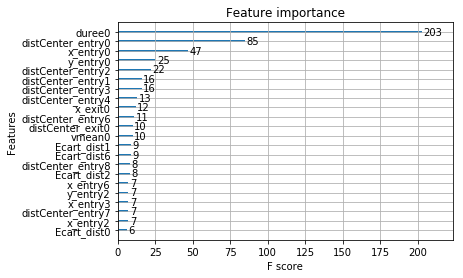

In [77]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
# load data

# plot feature importance
plot_importance(clf,max_num_features=22)
pyplot.savefig('feature_imp.png', bbox_inches='tight')
pyplot.show()

In [5]:
# #calculs des angles

#X[14] X[15] x et y entry
#X[16] X[17] x et y exit
#(3750901.5068+3770901.5068)/2 x centre
# = 3760901.5068
#(-19268905.6133+-19208905.6133)/2
# = -19238905.6133

# u = np.array([train.x_exit,train.y_exit])-np.array([train.x_entry,train.y_entry])
# v = np.array([x_centre-train.x_entry,y_centre-train.y_entry])

# angle_train = []
# for i in range(u.shape[1]):
#     scalar = (np.dot([u[0][i],u[1][i]],[v[0][i],v[1][i]]))
#     u_norm = (np.linalg.norm([u[0][i],u[1][i]]))
#     v_norm = (np.linalg.norm([v[0][i],v[1][i]]))
#     angle_train.append(degrees(acos(scalar/(u_norm*v_norm))))
    
# u = np.array([test.x_exit,test.y_exit])-np.array([test.x_entry,test.y_entry])
# v = np.array([3760901.5068-test.x_entry,-19238905.6133-test.y_entry])

# angle_test = []
# for i in range(u.shape[1]):
#     scalar = (np.dot([u[0][i],u[1][i]],[v[0][i],v[1][i]]))
#     u_norm = (np.linalg.norm([u[0][i],u[1][i]]))
#     v_norm = (np.linalg.norm([v[0][i],v[1][i]]))
#     angle_test.append(degrees(acos(scalar/(u_norm*v_norm))))

# #application

# train['angle']=angle_train
# test['angle']=angle_test

In [6]:
# from sklearn.model_selection import RandomizedSearchCV

# print(datetime.datetime.now())
# X = X
# y = Y.astype(int)
# param_grid = {
#     'n_jobs':[-1],
#     'n_estimators': [100,150,200,300],
#     'learning_rate': [0.01,0.05,0.1],
#     'max_depth': [5,12,14,17,19],
#     'min_child_weight': [0.4],
#     'n_jobs':[-1],
#     'colsample_bytree':[0.3,0.5,0.8],
#     'subsample' :[0.8,1]
# }
# XGBClassifier()

# kf = StratifiedKFold(n_splits=4,random_state=1,shuffle=True)
# random_search = RandomizedSearchCV(XGBClassifier(),param_grid,n_iter=5, cv=kf.split(X, y),verbose=3, scoring= 'f1',iid=True,n_jobs=-1)
# random_search.fit(X,y)

# print(datetime.datetime.now())


2019-05-01 23:46:30.896014
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:  6.8min remaining: 27.4min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed: 13.6min remaining: 11.2min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed: 16.4min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 16.7min finished


2019-05-02 00:04:51.994189


In [11]:
pd.DataFrame(random_search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_jobs,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,805.915529,30.117864,2.281324,0.312950,0.8,-1,200,0.4,12,0.05,...,0.885611,0.887532,0.001330,1,0.985967,0.986059,0.984791,0.986131,0.985737,0.000549
2,387.715264,15.529830,0.968381,0.125880,1,-1,200,0.4,5,0.05,...,0.883610,0.885576,0.001217,2,0.896642,0.897159,0.896381,0.898186,0.897092,0.000691
3,484.345139,4.387443,1.610464,0.189231,0.8,-1,150,0.4,14,0.1,...,0.881857,0.884363,0.001709,3,0.999194,0.999267,0.999011,0.999102,0.999143,0.000096
1,416.211441,15.038476,3.769427,0.333052,1,-1,200,0.4,12,0.1,...,0.881626,0.883667,0.001429,4,0.999194,0.998791,0.998864,0.999084,0.998983,0.000163
4,536.482058,2.363955,3.782681,0.427133,1,-1,300,0.4,12,0.01,...,0.876413,0.877536,0.001348,5,0.945794,0.946021,0.945636,0.946636,0.946022,0.000380


In [16]:
import time

print(datetime.datetime.now())
X = X
y = Y.astype(int)
param_grid = {
    'n_jobs':[-1],
    'n_estimators': [170,200,230],
    'learning_rate': [0.02,0.05],
    'max_depth': [10,12],
    'min_child_weight': [0.4],
    'n_jobs':[-1],
    'colsample_bytree':[0.8],
    'subsample' :[0.8,1]
}

kf = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
model = GridSearchCV(XGBClassifier(),param_grid, cv=kf.split(X, y),verbose=3, scoring= 'f1',iid=True,n_jobs=-1)
model.fit(X,y)

print(model.best_score_)
print(model.best_params_)

print(datetime.datetime.now())


2019-05-02 00:17:07.161631
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 145.5min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 535.6min finished


0.8877009016037539
{'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 12, 'min_child_weight': 0.4, 'n_estimators': 230, 'n_jobs': -1, 'subsample': 0.8}
2019-05-02 09:14:34.590405


In [73]:
#model = pickle.load(open('V2_XGB_best.pickle', 'rb'))
pickle.dump(model.best_estimator_,open('XGB_tuned_01','wb'))

In [15]:
from catboost import CatBoostClassifier

#model = CatBoostClassifier()
#model = XGBClassifier(random_state=1,n_jobs=-1)
model = LGBMClassifier(random_state=1,n_jobs=-1)
model.fit(X,Y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [16]:
#pd.DataFrame(model.cv_results_)

In [17]:
#print(model.best_estimator_)

In [18]:
# X =pd.read_csv('X.csv')
# X_test = pd.read_csv('X_test.csv')
# Y = pd.read_csv('Y.csv')

# model.fit(X,Y)

In [19]:
pred = model.predict(X_test)
#pred = model.predict_proba(X_test)
prediction = pd.DataFrame()

In [20]:
#pred = pd.DataFrame(pred)[1]

In [21]:
trajectory_id = tr['trajectory_id']

In [22]:
trajectory_id=trajectory_id.values
prediction['id']=trajectory_id
prediction['target']=pred

In [23]:
# pTreshold = np.where(prediction['target'] > 0.4565999999999999, 1,0)
# prediction['target'] = pTreshold

In [24]:
prediction.target.value_counts()

0    25066
1     8449
Name: target, dtype: int64

In [25]:
prediction.target = prediction.target.astype(int)
prediction.describe()

,target
count,33515.000000
mean,0.252096
std,0.434223
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [114]:
findOptimalTreshold(model,10)

In [26]:
prediction.to_csv("LGM_defaut_ecart.csv",index=False)
#0.46109999999999995 treshold
#0.8893500488666778

# Réseaux neuronnes

In [100]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [101]:
import tensorflow as tf
import theano # utilise à la fois le Cpu et le Gpu de l'ordinateur
import keras
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

scaler = StandardScaler()
X1_train=scaler.fit_transform(X_train)
X1_test=scaler.transform(X_test)

In [110]:
from keras.models import Sequential
from keras.layers import Dense

classifier = Sequential()
classifier.add(Dense(units=108,activation="relu",kernel_initializer="uniform",input_dim=217)) #1ere couche
classifier.add(Dense(units=108,activation="relu",kernel_initializer="uniform")) #couche cachée
classifier.add(Dense(units=1,activation="sigmoid",kernel_initializer="uniform")) #to get a proba
classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=[f1])

In [111]:
classifier.fit(X1_train, y_train,batch_size=10, epochs=100)

Epoch 1/100
100547/100547 [==============================] - 18s 178us/step - loss: 0.2870 - f1: 0.6663
Epoch 2/100
100547/100547 [==============================] - 18s 182us/step - loss: 0.2151 - f1: 0.7540
Epoch 3/100
100547/100547 [==============================] - 18s 180us/step - loss: 0.2037 - f1: 0.7633
Epoch 4/100
100547/100547 [==============================] - 19s 185us/step - loss: 0.1963 - f1: 0.7669
Epoch 5/100
100547/100547 [==============================] - 18s 183us/step - loss: 0.1917 - f1: 0.7753
Epoch 6/100
100547/100547 [==============================] - 17s 169us/step - loss: 0.1888 - f1: 0.7777
Epoch 7/100
100547/100547 [==============================] - 17s 171us/step - loss: 0.1871 - f1: 0.7829
Epoch 8/100
100547/100547 [==============================] - 17s 171us/step - loss: 0.1835 - f1: 0.7835
Epoch 9/100
100547/100547 [==============================] - 17s 170us/step - loss: 0.1826 - f1: 0.7886
Epoch 10/100
100547/100547 [==============================] - 17

100547/100547 [==============================] - 17s 170us/step - loss: 0.1226 - f1: 0.8410
Epoch 80/100
100547/100547 [==============================] - 17s 169us/step - loss: 0.1220 - f1: 0.8467
Epoch 81/100
100547/100547 [==============================] - 17s 170us/step - loss: 0.1224 - f1: 0.8426
Epoch 82/100
100547/100547 [==============================] - 17s 169us/step - loss: 0.1211 - f1: 0.8433
Epoch 83/100
100547/100547 [==============================] - 17s 170us/step - loss: 0.1206 - f1: 0.8421
Epoch 84/100
100547/100547 [==============================] - 17s 169us/step - loss: 0.1207 - f1: 0.8419
Epoch 85/100
100547/100547 [==============================] - 17s 170us/step - loss: 0.1225 - f1: 0.8471
Epoch 86/100
100547/100547 [==============================] - 17s 171us/step - loss: 0.1256 - f1: 0.8461
Epoch 87/100
100547/100547 [==============================] - 17s 170us/step - loss: 0.1267 - f1: 0.8425
Epoch 88/100
100547/100547 [==============================] - 17s 17

In [141]:
pred_neural = classifier.predict(X1_test)
result = (np.where(pred_neural>0.5,1,0)) 
print('f1_score',f1_score(y_test.values.astype(int),result.astype(int)))